In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [4]:
class DataLoader():
    def __init__(self, path, sep=",", header=None, cols=()):
        if(len(cols) == 0):
            self._df = pd.read_csv(path, sep=sep, header=header)
        else:
            temp_df = pd.read_csv(path, sep=sep, header=header)
            from_col, to_col = cols
            self._df = temp_df.iloc[:, from_col:to_col]
    @classmethod
    def normal_scaler(cls, x):
        eps = 1e-5
        mean = np.mean(x, axis=0)
        std = np.std(x, axis=0)
#         print("mean shape: {0}, std shape: {1}".format(mean.shape, std.shape))
#         print("mean: {0}, std: {1}".format(mean, std))
        x_scaled = (x-mean)/(std+eps)
        return x_scaled 
    def to_numpy(self, scale=True):
        arr = self._df.to_numpy()
        print("Shape: {0}".format(arr.shape))
        if(scale):
            return DataLoader.normal_scaler(arr)
        return arr
    def to_df(self):
        return self._df
    def rand_sample(self, size=200, scale=True):
        arr = self.to_numpy(scale)
        sample_indices = np.random.choice(arr.shape[0], size, replace=False)
        return arr[sample_indices]

## Lloyd's K-Means Algorithm


In [5]:
def k_means(X, k, centroids=None, itr_thres=100):
    print("K-means with k: {0}".format(k))
#     print("centroids:", centroids, centroids is None)
    def error(X, C):
        pair_dists = cdist(X, centroids)
        dist_from_center = np.min(pair_dists[:5], axis=1)
        se = np.linalg.norm(dist_from_center)**2
        return se
    def check_convergence(errors, thres=1e-5):
        if len(errors) < 2:
            return False
        else:
            if(abs(errors[-1]-errors[-2]) < thres):
                return True
        return False
    
    # k- random choices for centroids
    if(centroids is None):
        centroids = X[np.random.choice(X.shape[0], k, replace=False)].reshape(k, -1)
    errors = []
    count = 0
    while not check_convergence(errors):
        # Compute new centroids
        pair_dists = cdist(X, centroids)
        centroids_new = []
        min_value = np.argmin(pair_dists, axis=1)
        for j in range(k):
            Pj = X[min_value == j]
            centroids_new.append(np.mean(Pj, axis=0))
        centroids = np.array(centroids_new)
        errors.append(error(X, centroids))
        count += 1
        if(count > itr_thres):
            break
    print("# Iterations: {0}".format(count))
    return centroids, errors

### Implementing K-mean ++
#### K-means++ Algorithm
1. Randomly select the first centroid from the data points.
2. For each data point x not chosen yet, compute $D(x)$, the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to $D(x)^2$.
4. Repeat Steps 2 and 3 until k centers have been chosen.

In [6]:
def k_means_pp(X, k):
    print("X: {0}, k: {1}".format(X.shape, k))
    X_org = np.copy(X)
    # Step 1
    centroids = []
    cent_index = np.random.choice(X.shape[0], 1)
    centroids.append(X[cent_index].reshape(1, -1))
    X = np.delete(X, cent_index, axis=0)
    
    if(k == 1):
        return centroids
    
    # Step 4
    for i in range(k-1):
        # Step 2
        cent_np = np.array(centroids).reshape(-1, X.shape[1])
        pair_dists = cdist(X, cent_np)
        nearest_center_dist = np.min(pair_dists, axis=1)
        
        # Step 3
        new_cent_index = np.argmax(nearest_center_dist)
        centroids.append(X[new_cent_index].reshape(1, -1))
        X = np.delete(X, new_cent_index, axis=0)
     
    centroids = np.array(centroids).reshape(-1, X.shape[1])
    # Run k-means with the centroids
#     return centroids
    return k_means(X_org, k, centroids)

## NK-Means
#### To be done
* Initialize $Opt$ value in $nk\_means$ algorithm
* Clean and import POWER dataset

In [7]:
def nk_means(X, y, k, z, k_means_alg):
    pair_dists = cdist(X, X)
    # TO BE DONE: Determine the value of optimum cost value (opt)
    opt = 2**(X.shape[0]*(pair_dists.max()))
    r = 2*(opt/z)**0.5
    
    ball_counts = np.sum((pair_dists < r).astype(np.int32), axis=0)
    heavy = (ball_counts > 2*z)
    X_cleaned = X[heavy]
    y_cleaned = y[heavy]
    
    # calculating precision and recall
    total_outliers = len(y[y==1])
    total_num_pts_discarded = len(y)-len(y_cleaned)
    remaining_outliers = len(y_cleaned[y_cleaned==1])
    num_outliers_detected = total_outliers - remaining_outliers
    
    precision = num_outliers_detected/total_num_pts_discarded
    recall = num_outliers_detected/total_outliers
    
    return k_means_alg(X_cleaned, k), precision, recall     

## Coreset Construction

### Sample Coreset Algorithm

1. $p = max(\frac{36}{z}\log(\frac{4nk^2}{z}), 36\frac{k}{z}\log(2k^3))$
2. *if* (p > 1) **K-means++**$(X, 32(k+z))$
3. *else*, **K-means++**$(S, 32(k+2.5pz))$

$S$ be a sample drawn from $X$, where each $x ∈ X$ is included in $S$ independently with probability $p$

In [8]:
def sample_coreset(X, k, z):
    n = X.shape[0]
    p = max((36/z)*np.log((4*n/z)*k**2), (36*k/z)*np.log(2*(k**3)))
    print("Sample Coreset, p: {0}, X: {1}, k: {2}, z: {3}".format(p, X.shape, k, z))
    if(p > 1):
        return k_means_pp(X, int(32*(k+z)))
    else:
        proba = np.random.rand(X.shape[0])
        S = X[proba < p]
        return k_means_pp(S, int(32*(k+2.5*p*z)))

### K-means--

In [9]:
def k_means_mm(X, y, k, z, itr_thres=100):
    print("K-means-- with (k, z, itr_thres): ({0}, {1}, {2})".format(k, z, itr_thres))
    def error(X, C):
        pair_dists = cdist(X, centroids)
        dist_from_center = np.min(pair_dists[:5], axis=1)
        se = np.linalg.norm(dist_from_center)**2
        
        return se
    def check_convergence(errors, thres=1e-5):
        if len(errors) < 2:
            return False
        else:
            if(abs(errors[-1]-errors[-2]) < thres):
                return True
        return False
    # Number of ground truth outliers
    total_outliers = len(y[y==1])
    # k- random choices for centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)].reshape(k, -1)
    errors = []
    count = 0
    for i in range(20):
        # Compute d(x | Ci−1), for all x ∈ X
        pair_dists = cdist(X, centroids)
        nearest_center_dist = np.min(pair_dists, axis=1)

        # get the indices of sorted distance values
        sorted_indices = np.argsort(nearest_center_dist)
        # store the largest 'l' values in set 'L'
        L = X[sorted_indices[-z:]]
        
        # remove the set 'L' from 'X'
        X = np.delete(X, sorted_indices[-z:], axis=0)
        y = np.delete(y, sorted_indices[-z:], axis=0)
        
        # Compute new centroids
        pair_dists = cdist(X, centroids)
        centroids_new = []
        for j in range(k):
            min_value = np.argmin(pair_dists, axis=1)
            if(len(min_value) == 0):
#                 print("\tmin_value: {0}, breaking...".format(min_value))
                break
            Pj = X[min_value == j]
#             print("Itr: {0}, centroids: {1}".format(count, np.mean(Pj, axis=0)))
            centroids_new.append(np.mean(Pj, axis=0))
        if(len(centroids_new) == 0):
            break
        centroids = np.array(centroids_new)
        errors.append(error(X, centroids))
        count += 1
        if(count > itr_thres):
            break
    print("# Iterations: {0}".format(count))
    
    # calcluating precision and recall of outliers
    total_num_pts_discarded = count*z
    remaining_outliers = len(y[y==1])
    num_outliers_detected = total_outliers - remaining_outliers
    
    precision = num_outliers_detected/total_num_pts_discarded
    recall = num_outliers_detected/total_outliers
    
    return {'centroids': centroids, 'errors': errors, 'recall': recall, 'precision': precision}

## Gaussian Mixture

In [21]:
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
def gaussian_mixture(X, k):
    eps = 1e-5
    weights = np.ones((k)) / k
    means = np.random.choice(X.flatten(), (k, X.shape[1]))
    # create and initialize a Positive semidefinite convariance matrix 
    cov = []
    for i in range(k):
        cov.append(make_spd_matrix(X.shape[1]))
    cov = np.array(cov)
    print(cov.shape)
    step=1
    while step<15:
        likelihood = []
        # Expectation step
        for j in range(k):
            likelihood.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]))
        likelihood = np.array(likelihood)
        assert likelihood.shape == (k, len(X))

        b = []
        # Maximization step 
        for j in range(k):
            # use the current values for the parameters to evaluate the posterior
            # probabilities of the data to have been generanted by each gaussian
            b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))

            # updage mean and variance
            means[j] = np.sum(b[j].reshape(len(X),1) * X, axis=0) / (np.sum(b[j]+eps))
            cov[j] = np.dot((b[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(b[j])+eps)

            # update the weights
            weights[j] = np.mean(b[j])
    return means, cov, b

In [24]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(10)
labels = gm.fit_predict(X_skin)

# Experiments
## Prepare Datasets

In [12]:
def add_outliers(X, z, delta = 5):
    outliers = np.random.uniform(low=-delta, high=delta, size=(z, X.shape[1]))
    X = np.concatenate((X, outliers), axis=0)
    y = np.zeros((X.shape[0], 1))
    y[-z:] = 1
    return X, y

In [13]:
# SKIN-delta

skin_dl = DataLoader("datasets/skin/Skin_NonSkin.txt", sep="\t", cols=(0, 3))
X_skin = skin_dl.to_numpy()
k_skin = 10
z_skin = int(0.01*X_skin.shape[0])
skin_5_arr, y_skin_5 = add_outliers(X_skin, z_skin)
skin_10_arr, y_skin_10 = add_outliers(X_skin, z_skin, delta=10)


Shape: (245057, 3)


In [14]:
y_skin_5.shape, skin_5_arr.shape, X_skin.shape

((247507, 1), (247507, 3), (245057, 3))

In [15]:
susy_dl = DataLoader("datasets/susy/SUSY.csv", cols=(1, 19))
X_susy = susy_dl.to_numpy()
z_susy = int(0.01*X_susy.shape[0])
k_susy = 10
susy_5_arr, y_susy_5 = add_outliers(X_susy, z_susy)
susy_10_arr, y_susy_10 = add_outliers(X_susy, z_susy, delta=10)

Shape: (5000000, 18)


In [16]:
kdd_dl = DataLoader("datasets/kdd/kddcup.data", cols=(7, 41))
kdd_arr = kdd_dl.to_numpy()
k_kdd = 3
z_kdd = 45747

kdd_df = pd.read_csv("datasets/kdd/kddcup.data", header=None)
y_kdd = kdd_df[41].apply(lambda x: x in ('smurf.', 'neptune.', 'normal.')).values.astype(int)

Shape: (4898431, 34)


In [17]:
# POWER

power_df = pd.read_csv("datasets/power/household_power_consumption.txt", sep=";")
power_df2 = pd.DataFrame()
for col in power_df.iloc[:, 2:].columns.tolist():
    power_df2[col] = pd.to_numeric(power_df[col], errors='coerce').dropna()

X_power = DataLoader.normal_scaler(power_df2.to_numpy())
k_power = 10
z_power = int(0.01*X_power.shape[0])
power_5_arr, y_power_5 = add_outliers(X_power, z_power)
power_10_arr, y_power_10 = add_outliers(X_power, z_power, delta=10)

/Users/shashank/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
def plot_errors(res):
    print("Recall:\t\t{0}, \nPrecision:\t{1},\nMin Objective:\t{2}".
          format(res['recall'], res['precision'], min(res['errors'])))
    plt.plot(res['errors'])
    plt.show()

### K-means--

In [112]:
%%time
# SKIN-5
res_skin_5 = k_means_mm(skin_5_arr, y_skin_5, k_skin, int(z_skin*0.05))

K-means-- with (k, z, itr_thres): (10, 122, 100)
# Iterations: 20
CPU times: user 2.01 s, sys: 79.3 ms, total: 2.09 s
Wall time: 2.1 s


Recall:		0.7738775510204081, 
Precision:	0.7770491803278688,
Min Objective:	2.4555528023639304


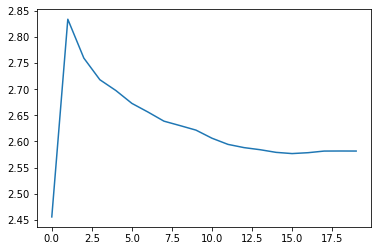

In [113]:
plot_errors(res_skin_5)

In [50]:
%%time
# SKIN-10
res_skin_10 = k_means_mm(skin_10_arr, y_skin_10, k_skin, int(z_skin*0.05))

K-means-- with (k, z, itr_thres): (10, 122, 100)
# Iterations: 20
CPU times: user 1.96 s, sys: 60.8 ms, total: 2.02 s
Wall time: 2.02 s


Recall:		0.9379591836734694, 
Precision:	0.9418032786885245,
Min Objective:	2.181104438144809


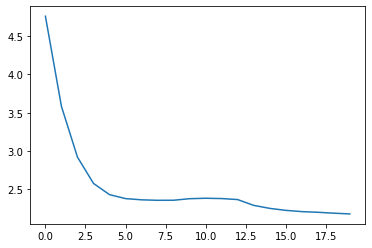

In [51]:
plot_errors(res_skin_10)

In [53]:
%%time
# SUSY-5
res_susy_5 = k_means_mm(susy_5_arr, y_susy_5, k_susy, int(z_susy*0.05))

K-means-- with (k, z, itr_thres): (10, 2500, 100)
# Iterations: 20
CPU times: user 1min 36s, sys: 11.9 s, total: 1min 48s
Wall time: 1min 50s


Recall:		0.79932, 
Precision:	0.79932,
Min Objective:	56.38377141538149


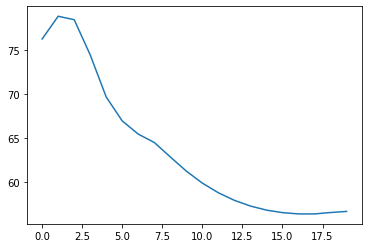

In [54]:
plot_errors(res_susy_5)

In [55]:
%%time
# SUSY-10
res_susy_10 = k_means_mm(susy_10_arr, y_susy_10, k_susy, int(z_susy*0.05))

K-means-- with (k, z, itr_thres): (10, 2500, 100)
# Iterations: 20
CPU times: user 1min 36s, sys: 12.9 s, total: 1min 49s
Wall time: 1min 50s


Recall:		0.98156, 
Precision:	0.98156,
Min Objective:	51.69765728799873


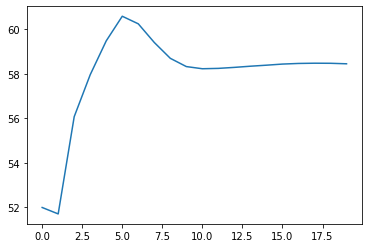

In [56]:
plot_errors(res_susy_10)

In [97]:
%%time
res_power_5 = k_means_mm(power_5_arr, y_power_5, k_power, int(z_power*0.05))

K-means-- with (k, z, itr_thres): (10, 1024, 100)
# Iterations: 20
CPU times: user 23.7 s, sys: 3.5 s, total: 27.2 s
Wall time: 27.3 s


Recall:		0.6298067538551629, 
Precision:	0.63017578125,
Min Objective:	44.47476519393946


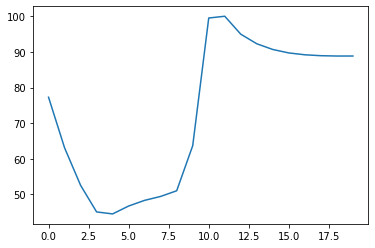

In [99]:
plot_errors(res_power_5)

In [98]:
%%time
res_power_10 = k_means_mm(power_10_arr, y_power_10, k_power, int(z_power*0.05))

K-means-- with (k, z, itr_thres): (10, 1024, 100)
# Iterations: 20
CPU times: user 23.3 s, sys: 3.49 s, total: 26.8 s
Wall time: 27 s


Recall:		0.9647667382393129, 
Precision:	0.96533203125,
Min Objective:	57.01193054016632


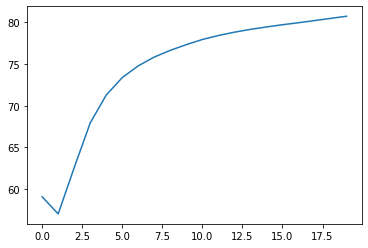

In [100]:
plot_errors(res_power_10)

In [130]:
%%time
# KDD
res_kdd = k_means_mm(kdd_arr, y_kdd, k_kdd, int(z_kdd*0.05))

K-means-- with (k, z, itr_thres): (3, 2287, 100)
# Iterations: 20
CPU times: user 48.9 s, sys: 14.6 s, total: 1min 3s
Wall time: 1min 3s


Recall:		0.0035543216908416045, 
Precision:	0.37708788806296456,
Min Objective:	155.69283490356918


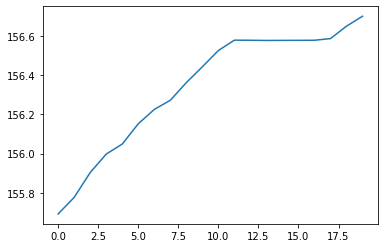

In [131]:
plot_errors(res_kdd)

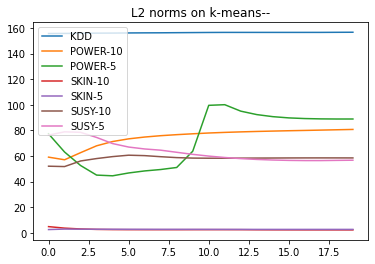

In [136]:
plt.plot(res_kdd['errors'], label="KDD")
plt.plot(res_power_10['errors'], label="POWER-10")
plt.plot(res_power_5['errors'], label="POWER-5")
plt.plot(res_skin_10['errors'], label="SKIN-10")
plt.plot(res_skin_5['errors'], label="SKIN-5")
plt.plot(res_susy_10['errors'], label="SUSY-10")
plt.plot(res_susy_5['errors'], label="SUSY-5")
plt.legend(loc="best")
plt.title("L2 norms on k-means--")
plt.show()

## k-means++ (Original)

In [114]:
%%time
# SKIN-5
cents_skin_5, errs_skin_5 = k_means_pp(skin_5_arr, k_skin)

X: (247507, 3), k: 10
K-means with k: 10
# Iterations: 12
CPU times: user 594 ms, sys: 74.2 ms, total: 669 ms
Wall time: 671 ms


In [144]:
print(min(errs_skin_5))

2.3034294153590125


In [116]:
%%time
# SKIN-10
cents_skin_10, errs_skin_10 = k_means_pp(skin_10_arr, k_skin)

X: (247507, 3), k: 10
K-means with k: 10
# Iterations: 10
CPU times: user 497 ms, sys: 64 ms, total: 561 ms
Wall time: 560 ms


In [143]:
print(min(errs_skin_10))

7.110514299207601


In [118]:
%%time
# SUSY-5
cents_susy_5, errs_susy_5 = k_means_pp(susy_5_arr, k_susy)

X: (5050000, 18), k: 10
K-means with k: 10
# Iterations: 101
CPU times: user 3min 31s, sys: 36.5 s, total: 4min 7s
Wall time: 4min 9s


In [142]:
print(min(errs_susy_5))

52.9273606274847


In [120]:
%%time
# SUSY-10
cents_susy_10, errs_susy_10 = k_means_pp(susy_10_arr, k_susy)

X: (5050000, 18), k: 10
K-means with k: 10
# Iterations: 101
CPU times: user 3min 21s, sys: 37.9 s, total: 3min 59s
Wall time: 4min 1s


In [141]:
print(min(errs_susy_10))

60.31559614583672


In [122]:
%%time
# POWER-5
cents_power_5, errs_power_5 = k_means_pp(power_5_arr, k_power)

X: (2069772, 7), k: 10
K-means with k: 10
# Iterations: 59
CPU times: user 24.7 s, sys: 5.2 s, total: 29.9 s
Wall time: 30 s


In [140]:
print(min(errs_power_5))

57.948004207015494


In [124]:
%%time
# POWER-10
cents_power_10, errs_power_10 = k_means_pp(power_10_arr, k_power)

X: (2069772, 7), k: 10
K-means with k: 10
# Iterations: 101
CPU times: user 41.5 s, sys: 8.99 s, total: 50.5 s
Wall time: 50.7 s


In [139]:
print(min(errs_power_10))

196.0934232046435


In [128]:
%%time
# KDD
cents_kdd, errs_kdd = k_means_pp(kdd_arr, k_kdd)

X: (4898431, 34), k: 3
K-means with k: 3
# Iterations: 2
CPU times: user 6.83 s, sys: 3.85 s, total: 10.7 s
Wall time: 10.7 s


In [138]:
print(min(errs_kdd))

146.08952054289136


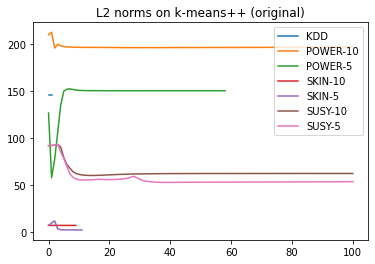

In [137]:
plt.plot(errs_kdd, label="KDD")
plt.plot(errs_power_10, label="POWER-10")
plt.plot(errs_power_5, label="POWER-5")
plt.plot(errs_skin_10, label="SKIN-10")
plt.plot(errs_skin_5, label="SKIN-5")
plt.plot(errs_susy_10, label="SUSY-10")
plt.plot(errs_susy_5, label="SUSY-5")
plt.legend(loc="best")
plt.title("L2 norms on k-means++ (original)")
plt.show()

## NK-means

In [ ]:
# SKIN-5
skin_5_nkmeans, skin_5_precision, skin_5_recall = nk_means(skin_5_arr, y_skin_5, k_skin, z_skin, k_means_pp)